# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

In [2]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate, BatchNormalization
from keras.models import Sequential, Model
from keras.utils import np_utils, plot_model
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
# Load data
images_dir = os.listdir("../input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data")

images_path = '../input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/'
captions_path = '../input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = '../input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = '../input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = '../input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [4]:
# Loading captions as values and images as key in dictionary
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

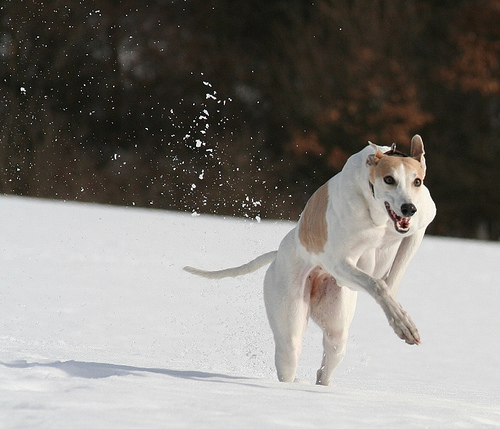

A brown and white dog is running through the snow .
A dog is running in the snow
A dog running through snow .
a white and brown dog is running through a snow covered field .
The white and brown dog is running over the surface of the snow .


In [5]:
# displaying an image and captions given to it
temp = captions[50].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [6]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [7]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
# test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [8]:
# Loading 50 layer Residual Network Model and getting the summary of the model
from IPython.core.display import display, HTML
display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

# Note: For more details on ResNet50 architecture you can click on hyperlink given below

94773248/94765736 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

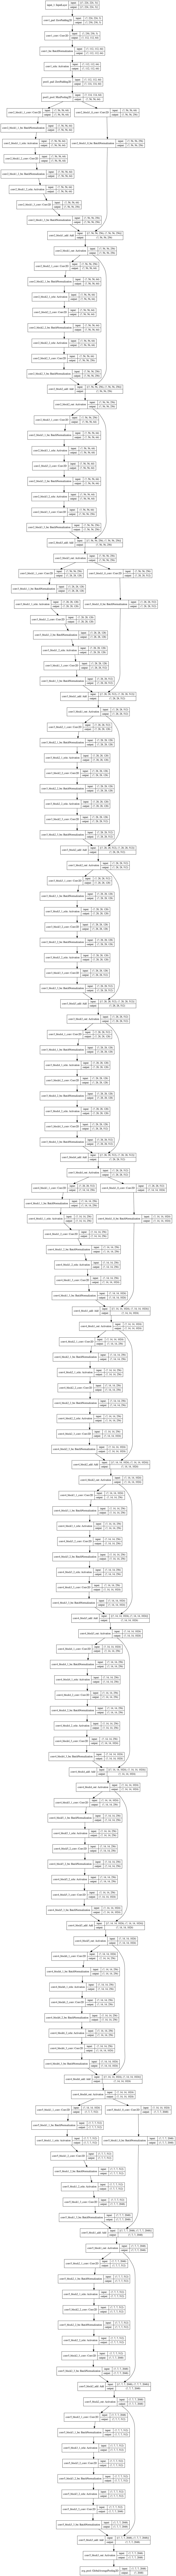

In [10]:
# plot the model
plot_model(model, show_shapes=True)

In [11]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)   # Add batch dimension
    return im

In [12]:
train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

1000
2000
3000


In [13]:
train_data['2513260012_03d33305cf.jpg'].shape

(2048,)

In [14]:
# opening train_encoded_images.p file and dumping it's content
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )  

In [15]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [16]:
pd_dataset.head()

image_id  \
0  2513260012_03d33305cf.jpg   
1  2513260012_03d33305cf.jpg   
2  2513260012_03d33305cf.jpg   
3  2513260012_03d33305cf.jpg   
4  2513260012_03d33305cf.jpg   

                                            captions  
0  <start> A black dog is running after a white d...  
1  <start> Black dog chasing brown dog through sn...  
2  <start> Two dogs chase each other across the s...  
3  <start> Two dogs play together in the snow . <...  
4  <start> Two dogs running through a low lying b...

In [17]:
# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

30000


In [18]:
# First 5 captions stored in sentences
sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [19]:
# Splitting each captions stored in 'sentences' and storing them in 'words' as list of list
words = [i.split() for i in sentences]

In [20]:
# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


In [21]:
# Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [22]:
word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253

In [23]:
indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

In [24]:
print(word_2_indices['<start>'])
print(indices_2_word[4011])
print(word_2_indices['<end>'])
print(indices_2_word[8051])

5610
shore
531
themselves


In [25]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

8254


In [26]:
# calculates the maximum length of captions in terms of the number of words
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [27]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

(30000,)
(30000,)


In [28]:
print(padded_sequences[0])

[[5610    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [5610  845    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [5610  845  676    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [5610  845  676 6918    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [5610  845  676 6918 2560    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [29]:
# prints out each padded sequence of partial captions for the first caption in the dataset, where each word is converted back from its index representation using the indices_2_word dictionary. It also prints the total number of partial sequences generated from the first caption

for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[0][ix][iy]],end=" ")
    print("\n")

print(len(padded_sequences[0]))

<start> UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 

<start> A UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 

<start> A black UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 

<start> A black dog UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 

<start> A black dog is UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 

<start> A black dog is running UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 

<sta

In [30]:
### # num_of_images = 3500
num_of_images = 3000

In [31]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [32]:
for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(38161, 40)
(38161, 8254)


In [33]:
with open('../input/flickr8k/145129_343604_compressed_train_encoded_images.p/train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

In [34]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0].encode() in encoded_images.keys():
#         print(ix, encoded_images[ds[ix, 0].encode()])
        imgs.append(list(encoded_images[ds[ix, 0].encode()]))

imgs = np.asarray(imgs)
print(imgs.shape)

(15000, 2048)


In [35]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(38161, 2048)


In [36]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

38161


###  **Model**

In [37]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(next_words.shape)

# (25493, 40)
# (25493, 8254)

(38161, 40)
(38161, 8254)


In [38]:
images = np.load("images.npy")

print(images.shape)

(38161, 2048)


In [39]:
imag = np.load("image_names.npy")
        
print(imag.shape)

(38161,)


In [40]:
embedding_size = 128
max_len = 40

In [41]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))


# Add Dense layer with ReLU activation function
image_model.add(Dense(512, input_shape=(2048,)))
image_model.add(Activation('relu'))

# Add Dropout layer to prevent overfitting
image_model.add(Dropout(0.5))

# Add BatchNormalization layer to stabilize and accelerate training
image_model.add(BatchNormalization())

# Add another Dense layer with ReLU activation function
image_model.add(Dense(256))
image_model.add(Activation('relu'))

# Add Dropout layer
image_model.add(Dropout(0.5))

# Add BatchNormalization layer
image_model.add(BatchNormalization())

# Add the final Dense layer
image_model.add(Dense(embedding_size))

image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               66048     
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0

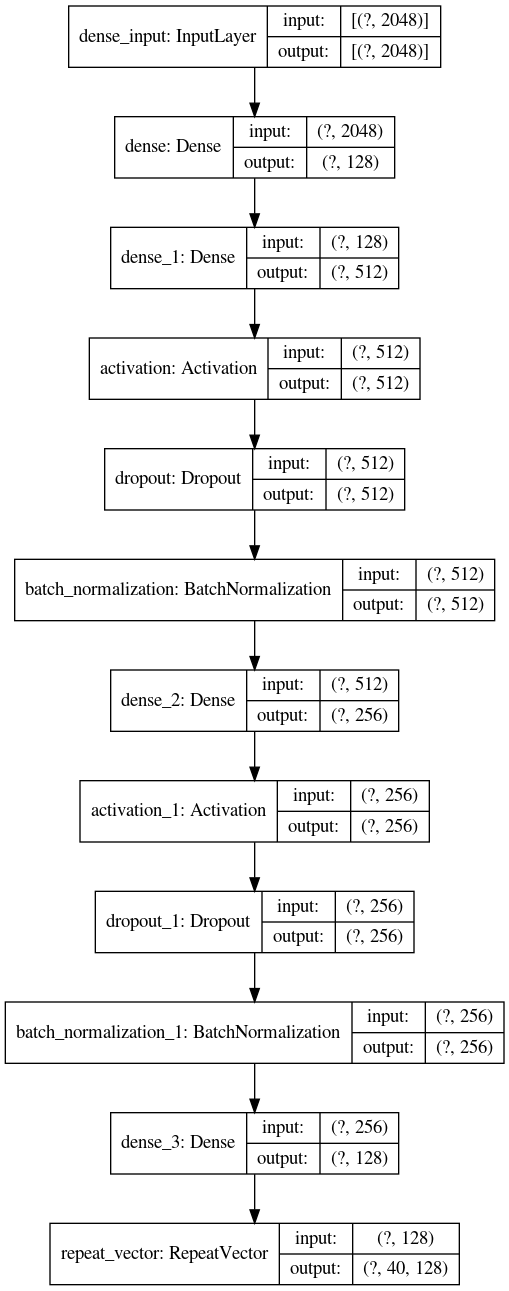

In [38]:
# plot the model
plot_model(image_model, show_shapes=True)

In [42]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
# language_model.add(LSTM(256, return_sequences=True))
# language_model.add(TimeDistributed(Dense(embedding_size)))


# Add Bidirectional LSTM layer with 256 units and return sequences
language_model.add(Bidirectional(LSTM(256, return_sequences=True)))

# Add Dropout layer to prevent overfitting
language_model.add(Dropout(0.5))

# Add TimeDistributed Dense layer with output size equal to embedding_size
# language_model.add(TimeDistributed(Dense(embedding_size)))

# Add another Bidirectional LSTM layer
language_model.add(Bidirectional(LSTM(256, return_sequences=True)))

# Add Dropout layer
language_model.add(Dropout(0.5))

# Add TimeDistributed Dense layer
language_model.add(TimeDistributed(Dense(embedding_size)))


language_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           1056512   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 512)           788480    
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 512)           1574912   
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 512)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 128)           65664     
Total params: 3,485,568
Trainable params: 3,485,568
Non-trainable params: 0
____________________________________________

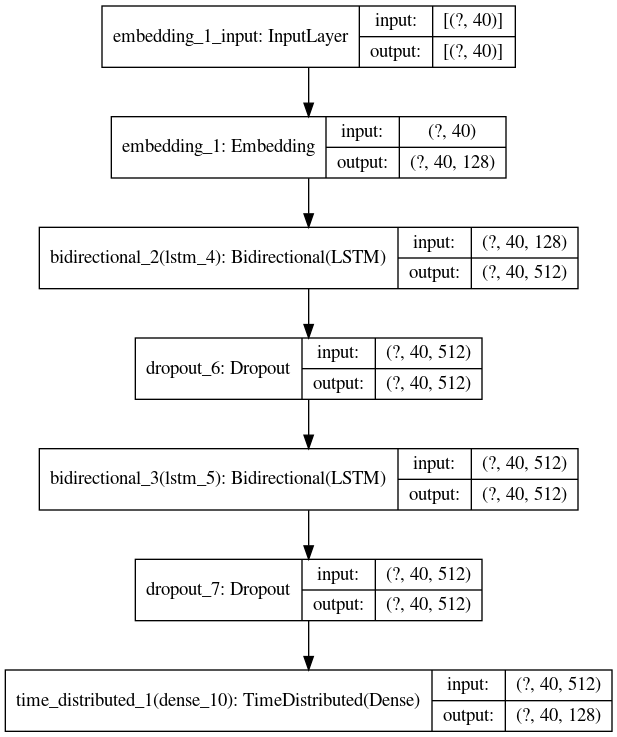

In [66]:
# plot the model
plot_model(language_model, show_shapes=True)

In [43]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          66048       dense[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 512)          0           dense_1[0][0]                    
_______________________________________________________________________________________

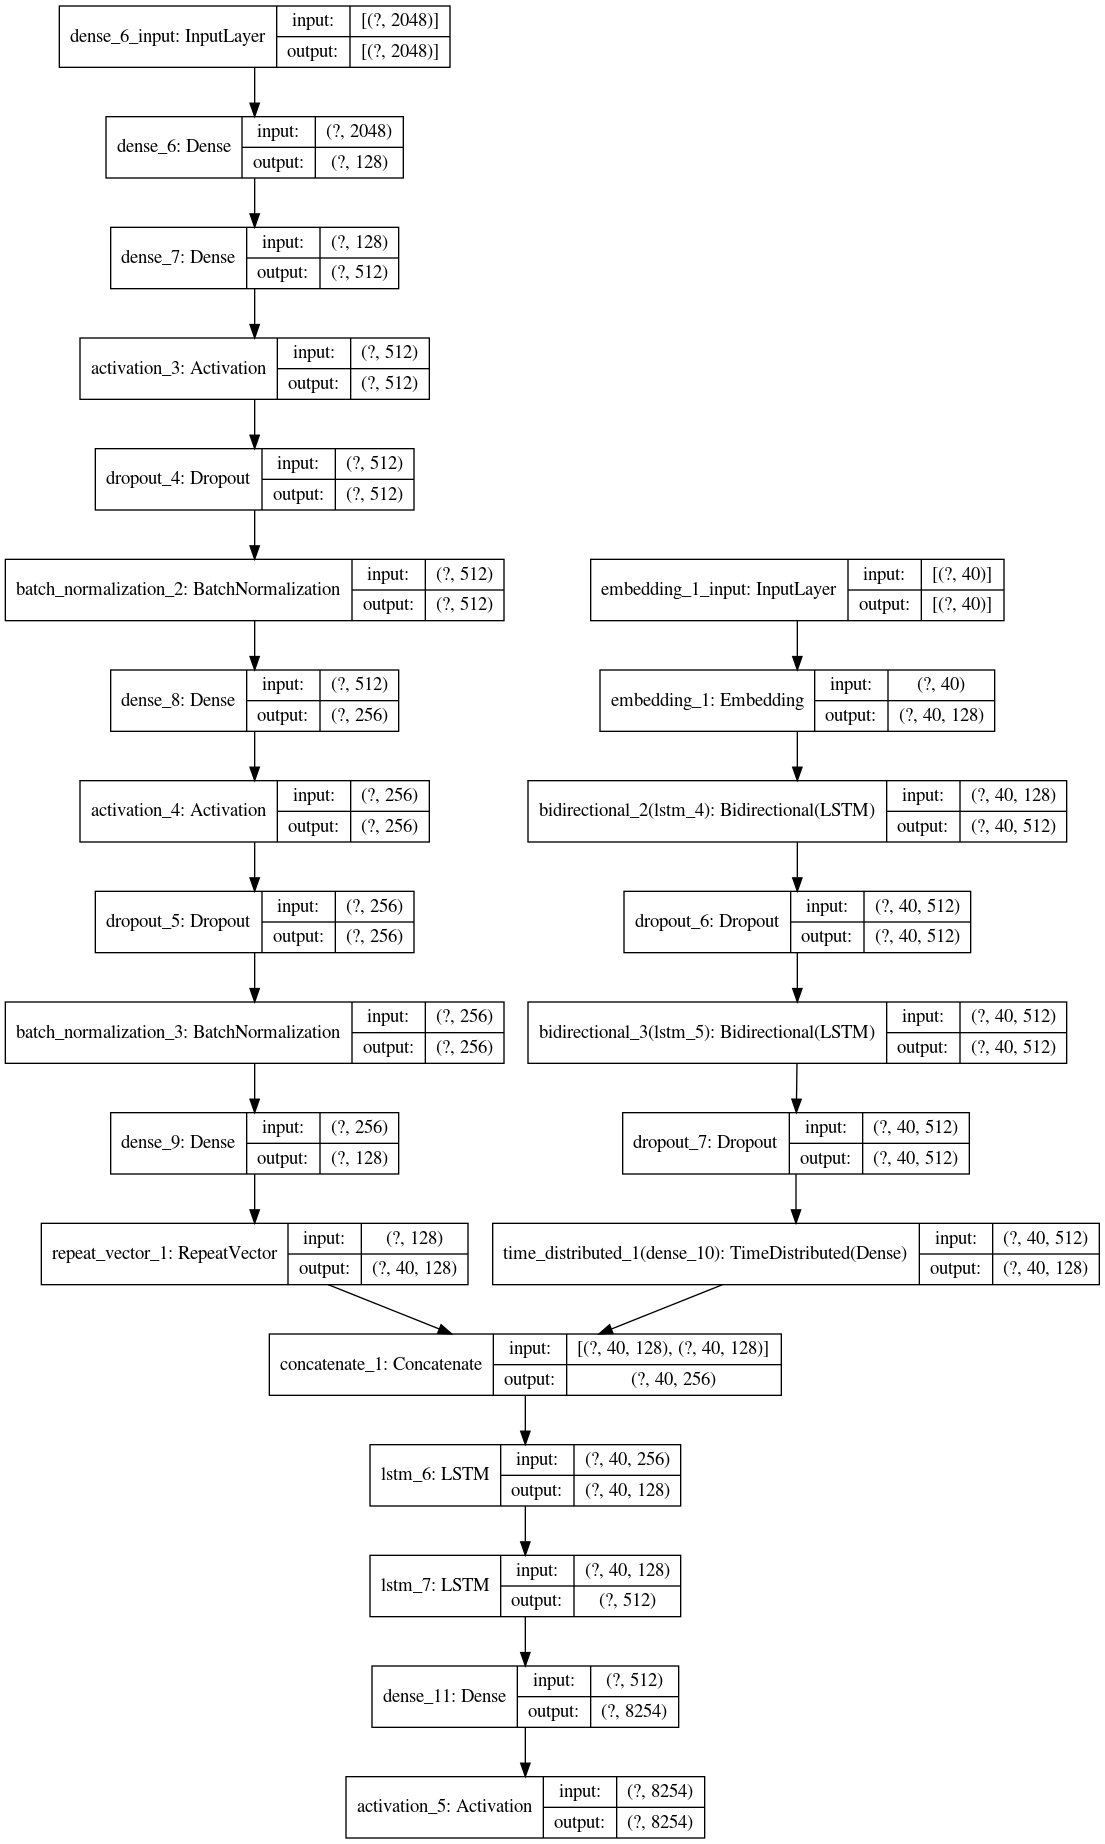

In [68]:
# plot the model
plot_model(model, show_shapes=True)

In [44]:
# hist = model.fit([images, captions], next_words, batch_size=512, epochs=179)
hist = model.fit([images, captions], next_words, batch_size=512, epochs=170)

# hist = model.fit([images, captions], next_words, batch_size=512, epochs=180)
# hist = model.fit([images, captions], next_words, batch_size=512, epochs=190, validation_split=0.2)


Epoch 1/170
75/75 [==============================] - 14s 191ms/step - loss: 5.6530 - accuracy: 0.0751
Epoch 2/170
75/75 [==============================] - 14s 192ms/step - loss: 5.2891 - accuracy: 0.0777
Epoch 3/170
75/75 [==============================] - 14s 189ms/step - loss: 5.1865 - accuracy: 0.0849
Epoch 4/170
75/75 [==============================] - 14s 185ms/step - loss: 4.9142 - accuracy: 0.1359
Epoch 5/170
75/75 [==============================] - 14s 187ms/step - loss: 4.6247 - accuracy: 0.1892
Epoch 6/170
75/75 [==============================] - 14s 187ms/step - loss: 4.3778 - accuracy: 0.2367
Epoch 7/170
75/75 [==============================] - 14s 188ms/step - loss: 4.2533 - accuracy: 0.2546
Epoch 8/170
75/75 [==============================] - 14s 189ms/step - loss: 4.1727 - accuracy: 0.2617
Epoch 9/170
75/75 [==============================] - 14s 188ms/step - loss: 4.1880 - accuracy: 0.2612
Epoch 10/170
75/75 [==============================] - 14s 187ms/step - loss: 4.065

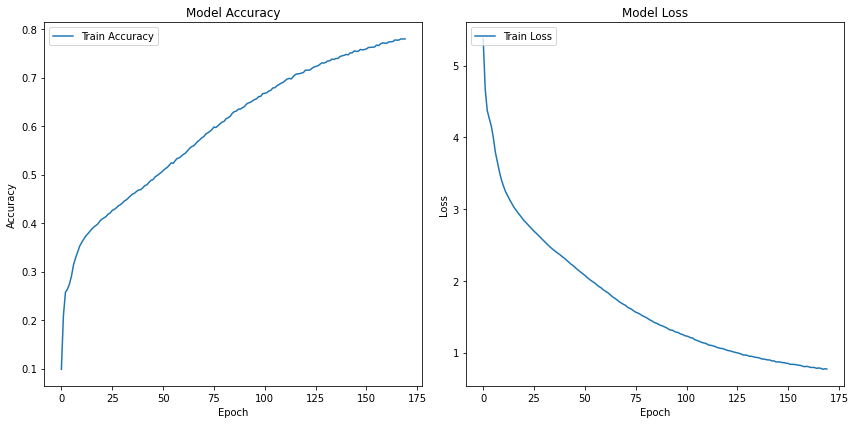

In [42]:
import matplotlib.pyplot as plt

# Fit the model
# hist = model.fit([images, captions], next_words, batch_size=512, epochs=180)

# Plot training accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


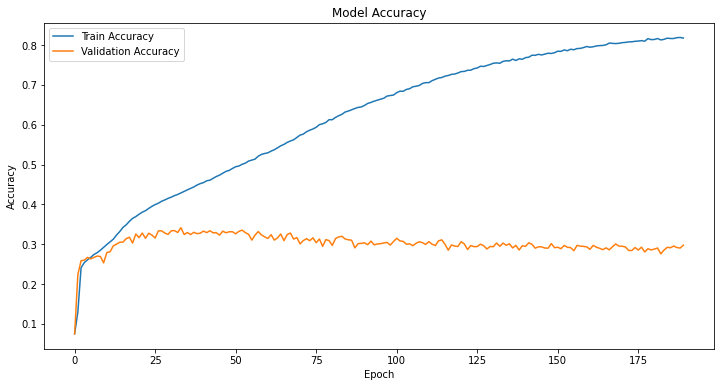

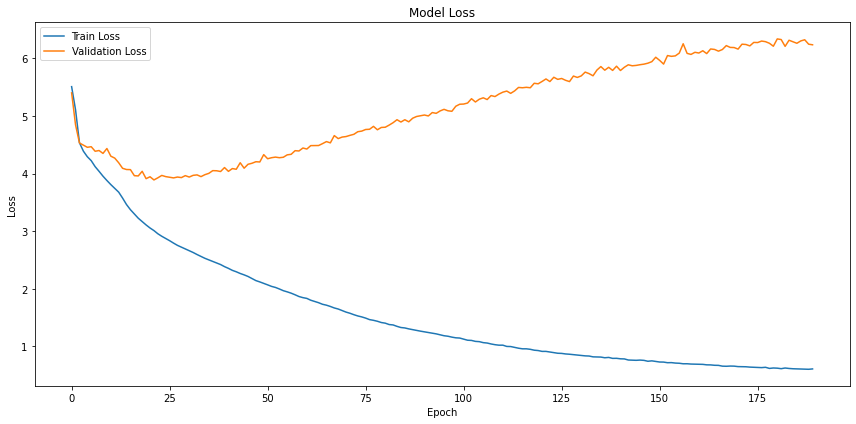

In [46]:
import matplotlib.pyplot as plt

# Fit the model with validation split
# hist = model.fit([images, captions], next_words, batch_size=512, epochs=180, validation_split=0.2)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Loss plot
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [46]:
model.save_weights("model_weights.h5")

In [47]:
!pip install nltk

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [49]:
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# # Function to map token indices to words
# def idx_to_word(integer, tokenizer):
#     for word, index in tokenizer.word_index.items():
#         if index == integer:
#             return word
#     return None

# # Function to generate captions for an image
# def generate_caption(model, tokenizer, photo, max_len):
#     in_text = 'startseq'
#     for i in range(max_len):
#         sequence = tokenizer.texts_to_sequences([in_text])[0]
#         sequence = pad_sequences([sequence], maxlen=max_len)
#         yhat = model.predict([photo, sequence], verbose=0)
#         yhat = np.argmax(yhat)
#         word = idx_to_word(yhat, tokenizer)
#         if word is None:
#             break
#         in_text += ' ' + word
#         if word == 'endseq':
#             break
#     final_caption = in_text.split()
#     final_caption = final_caption[1:-1]  # Remove 'startseq' and 'endseq'
#     return ' '.join(final_caption)

# # Load your test dataset
# test_images, test_captions = test_dataset

# # Preprocess the captions (already covered in your previous code)
# preprocessed_test_captions = preprocess_captions(test_captions, tokenizer, max_len)

# # Extract image features for the test images
# test_image_features = extract_image_features(test_images)

# # Generate captions for the test images
# generated_captions = []
# for img_feature in test_image_features:
#     img_feature = img_feature.reshape((1, 2048))  # Reshape as needed for your model
#     caption = generate_caption(model, tokenizer, img_feature, max_len)
#     generated_captions.append(caption)

# # Compute BLEU scores
# smoothie = SmoothingFunction().method4
# bleu_scores = []

# for i, caption in enumerate(generated_captions):
#     reference = [test_captions[i].split()]  # Tokenized reference caption
#     candidate = caption.split()  # Tokenized generated caption
#     bleu = sentence_bleu(reference, candidate, smoothing_function=smoothie)
#     bleu_scores.append(bleu)

# # Print average BLEU score
# average_bleu = np.mean(bleu_scores)
# print(f'Average BLEU score: {average_bleu}')


ValueError: I/O operation on closed file.

### Predictions

In [43]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [44]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [45]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [67]:

# img = "/kaggle/input/testimage/finaltestimage/dog1.jpg"
# img = "/kaggle/input/testimage/finaltestimage/sunilChetrikick.jpeg"
# img = "../input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1072153132_53d2bb1b60.jpg"# ----
# img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1056873310_49c665eb22.jpg"
# img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1016887272_03199f49c4.jpg"

# img = "/kaggle/input/testimage/finaltestimage/iplmasdhoni.jpeg"

# img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1020651753_06077ec457.jpg"
# img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/102351840_323e3de834.jpg"
img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1015584366_dfcec3c85a.jpg"

# img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1022454428_b6b660a67b.jpg"

# img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1075716537_62105738b4.jpg"
# img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1001773457_577c3a7d70.jpg"


test_img = get_encoding(resnet, img)

In [71]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

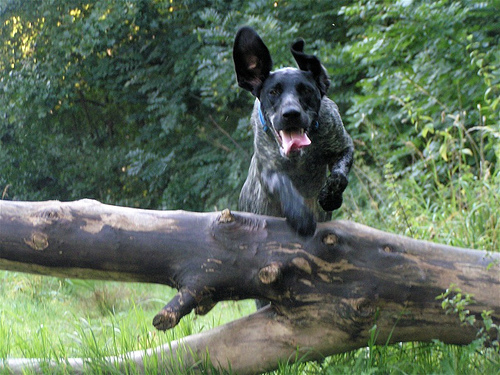

A black dog is running over a bridge .


In [69]:
from keras.preprocessing import image
z = Image(filename=img)
display(z)

print(Argmax_Search)

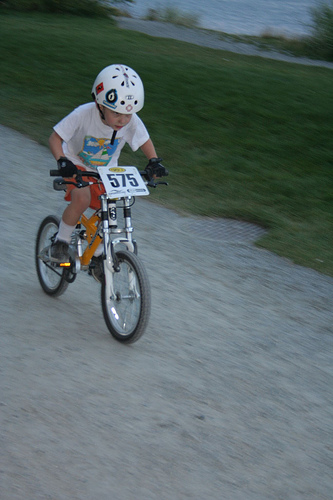

A boy performs a jumping bike trick on his yellow bike .


In [75]:

img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1075716537_62105738b4.jpg"

test_img = get_encoding(resnet, img)

Argmax_Search = predict_captions(test_img)

z = Image(filename=img)
display(z)

print(Argmax_Search)

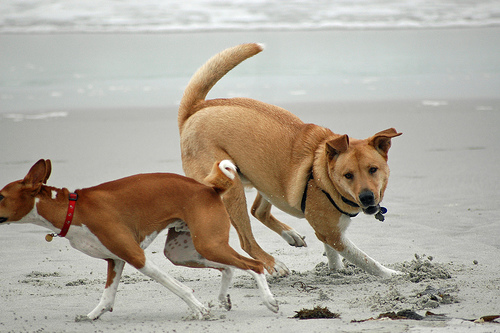

Two dogs , one brown and the other black , play in the sand


In [83]:
img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1024138940_f1fefbdce1.jpg"

test_img = get_encoding(resnet, img)

Argmax_Search = predict_captions(test_img)

z = Image(filename=img)
display(z)

print(Argmax_Search)

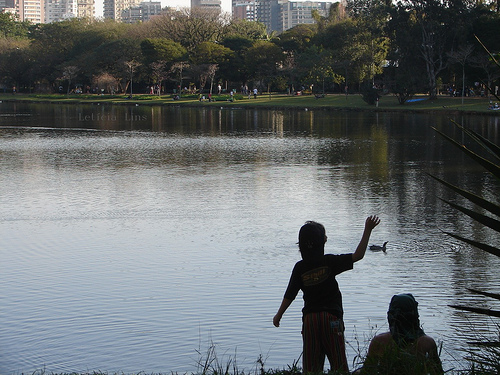

A child plays in front of an in shallow water .


In [86]:
img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1022454332_6af2c1449a.jpg"
test_img = get_encoding(resnet, img)

Argmax_Search = predict_captions(test_img)

z = Image(filename=img)
display(z)

print(Argmax_Search)

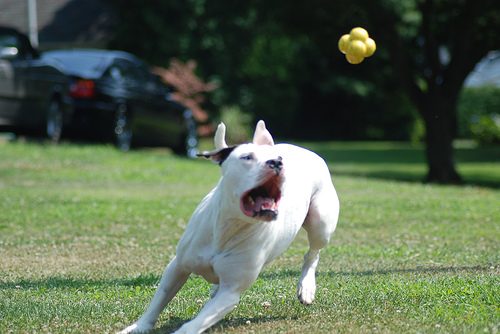

A fluffy dog is jumping and catching a toy .


In [87]:
img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1019604187_d087bf9a5f.jpg"
test_img = get_encoding(resnet, img)

Argmax_Search = predict_captions(test_img)

z = Image(filename=img)
display(z)

print(Argmax_Search)

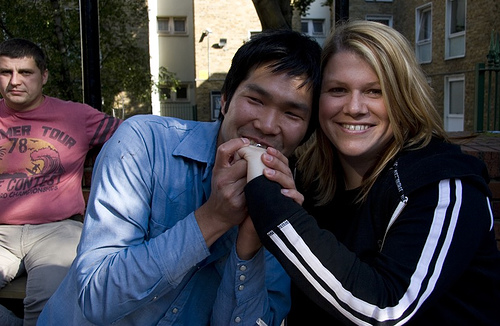

A man and a woman stand close together .


In [89]:
img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1042590306_95dea0916c.jpg"
test_img = get_encoding(resnet, img)

Argmax_Search = predict_captions(test_img)

z = Image(filename=img)
display(z)

print(Argmax_Search)

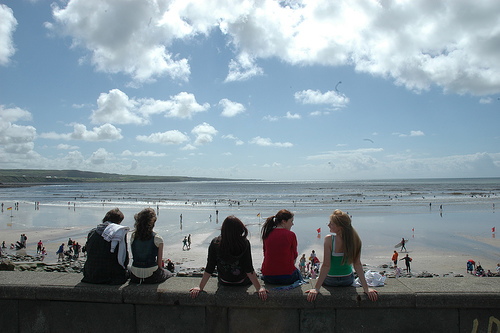

A group of people wearing life jackets riding a raft through rough waters .


In [99]:
img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1048710776_bb5b0a5c7c.jpg"
test_img = get_encoding(resnet, img)

Argmax_Search = predict_captions(test_img)

z = Image(filename=img)
display(z)

print(Argmax_Search)

In [100]:
img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/106490881_5a2dd9b7bd.jpg"
# img = "/kaggle/input/testimage/finaltestimage/sunilChetrikick.jpeg"

test_img = get_encoding(resnet, img)
Argmax_Search = predict_captions(test_img)

In [101]:
# def predict_captions(image):
#     start_word = ["<start>"]
#     while True:
#         par_caps = [word_2_indices[i] for i in start_word]
#         par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
#         preds = model.predict([np.array([image]), np.array(par_caps)])
#         word_pred = indices_2_word[np.argmax(preds[0])]
#         start_word.append(word_pred)
        
#         if word_pred == "<end>" or len(start_word) > max_len:
#             break
            
#     return ' '.join(start_word[1:-1])



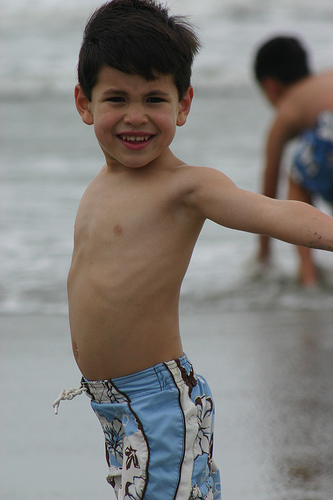

A boy jumping in the water near a spray street while another child looks on .


In [102]:
from keras.preprocessing import image
z = Image(filename=img)
display(z)

print(Argmax_Search)

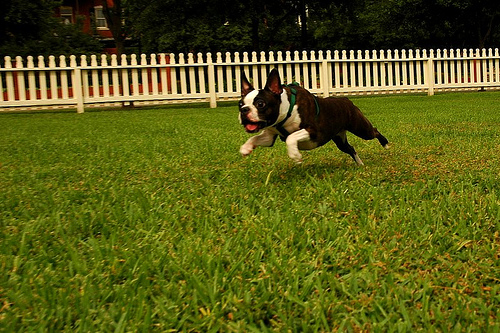

A dog is running through a Frisbee .


In [100]:
img = "/kaggle/input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/1009434119_febe49276a.jpg"
# img = "/kaggle/input/testimage/finaltestimage/sunilChetrikick.jpeg"

test_img = get_encoding(resnet, img)

Argmax_Search = predict_captions(test_img)

z = Image(filename=img)
display(z)

print(Argmax_Search)